In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define directories
ROOT_DIR = os.getcwd()
INPUT_DIR = os.path.join(ROOT_DIR, "../datasets/optimized")
PLOTS_DIR = os.path.join(ROOT_DIR, "..", "plots")

# Ensure output directory exists
os.makedirs(PLOTS_DIR, exist_ok=True)

# File paths for datasets
data_files = {
    "day_ahead_prices": "optimized_refined_Day-ahead_prices_202301010000_202503050000_Hour.csv",
    "actual_consumption": "optimized_refined_Actual_consumption_202301010000_202503050000_Quarterhour.csv",
    "actual_generation": "optimized_refined_Actual_generation_202301010000_202503050000_Quarterhour.csv",
    "forecast_generation": "optimized_refined_Forecasted_generation_Day-Ahead_202301010000_202503050000_Hour_Quarterhour.csv",
    "cross_border_flows": "optimized_refined_Cross-border_physical_flows_202301010000_202503050000_Quarterhour.csv",
    "balancing_reserves": "optimized_refined_Balancing_energy_202301010000_202503050000_Quarterhour_Month.csv",
    "tso_costs": "optimized_refined_Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv",
    "scheduled_exchanges": "optimized_refined_Scheduled_commercial_exchanges_202301010000_202503050000_Quarterhour.csv",
}

# Load datasets into DataFrames
datasets = {}
for key, filename in data_files.items():
    file_path = os.path.join(INPUT_DIR, filename)
    try:
        datasets[key] = pd.read_csv(file_path, delimiter=",", low_memory=False)
        print(f"Loaded: {filename}")
    except FileNotFoundError:
        print(f"Warning: {filename} not found in {INPUT_DIR}")

# Access datasets
df_prices = datasets.get("day_ahead_prices")
df_consumption = datasets.get("actual_consumption")
df_generation = datasets.get("actual_generation")
df_forecast = datasets.get("forecast_generation")
df_cross_border = datasets.get("cross_border_flows")
df_balancing = datasets.get("balancing_reserves")
df_tso = datasets.get("tso_costs")
df_exchanges = datasets.get("scheduled_exchanges")


Loaded: optimized_refined_Day-ahead_prices_202301010000_202503050000_Hour.csv
Loaded: optimized_refined_Actual_consumption_202301010000_202503050000_Quarterhour.csv
Loaded: optimized_refined_Actual_generation_202301010000_202503050000_Quarterhour.csv
Loaded: optimized_refined_Forecasted_generation_Day-Ahead_202301010000_202503050000_Hour_Quarterhour.csv
Loaded: optimized_refined_Cross-border_physical_flows_202301010000_202503050000_Quarterhour.csv
Loaded: optimized_refined_Balancing_energy_202301010000_202503050000_Quarterhour_Month.csv
Loaded: optimized_refined_Costs_of_TSOs__without_costs_of_DSOs__202301010000_202503050000_Month.csv
Loaded: optimized_refined_Scheduled_commercial_exchanges_202301010000_202503050000_Quarterhour.csv


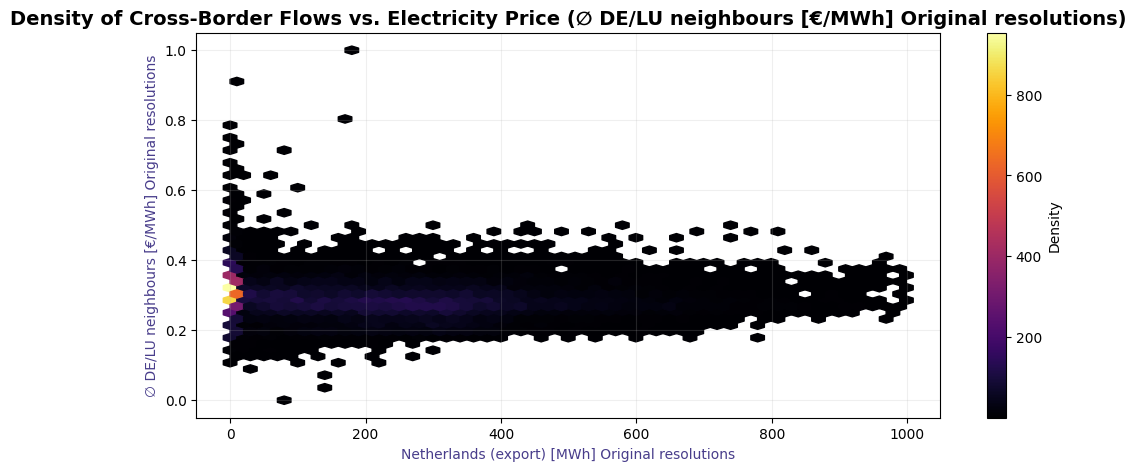

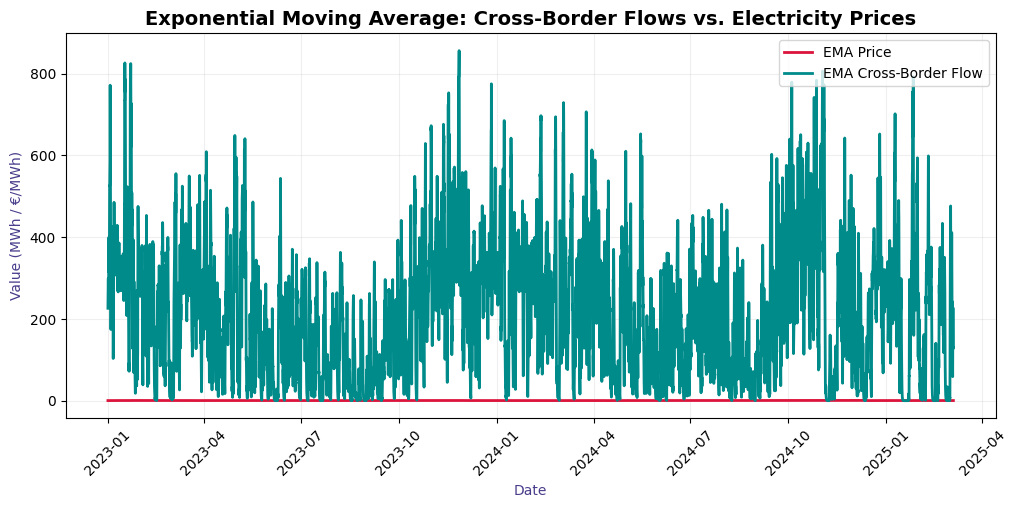

C:\Users\Elite\AppData\Local\Temp\ipykernel_22928\4149646487.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Feature", y="Value", data=melted_data, palette="coolwarm")


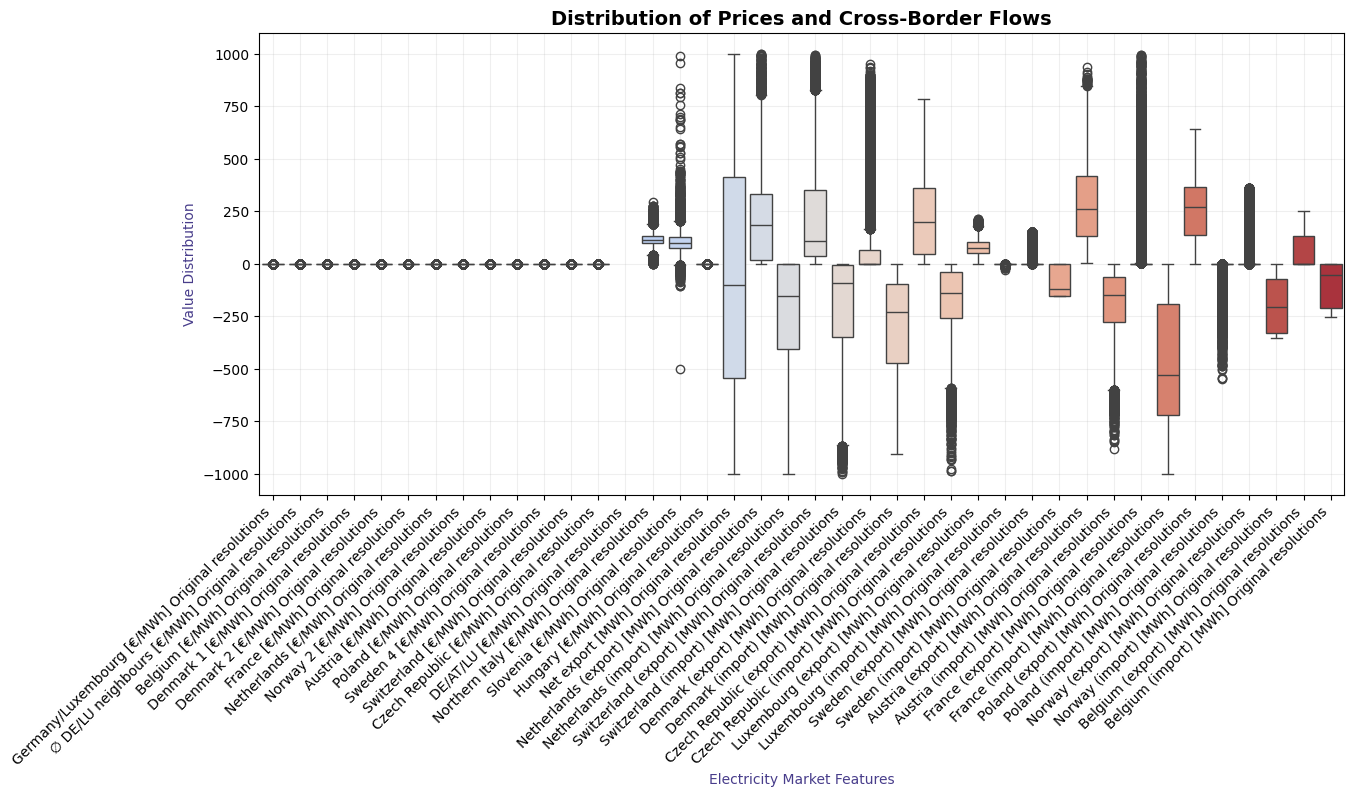

✅ Cross-border flows plots saved


In [4]:
### --- Cross-border flows vs price --- ###

# Convert time column to datetime
df_cross_border["Start date"] = pd.to_datetime(df_cross_border["Start date"], errors="coerce")
df_prices["Start date"] = pd.to_datetime(df_prices["Start date"], errors="coerce")

# Merge datasets on "Start date"
df_combined = df_prices.merge(df_cross_border, on="Start date", how="inner")

# Identify relevant columns
price_cols = [col for col in df_prices.columns if "€/MWh" in col]
flow_cols = [col for col in df_cross_border.columns if "[MWh]" in col]

# Convert columns to numeric
df_combined[price_cols] = df_combined[price_cols].apply(pd.to_numeric, errors="coerce")
df_combined[flow_cols] = df_combined[flow_cols].apply(pd.to_numeric, errors="coerce")

# Randomly select a country for analysis
selected_price = price_cols[1]  # Pick a different index than the first one
selected_flow = flow_cols[1]

# 📌 **1️⃣ Hexbin Plot for Density Representation**
plt.figure(figsize=(12, 5))
plt.hexbin(
    df_combined[selected_flow], df_combined[selected_price], gridsize=50, cmap="inferno", mincnt=1
)
plt.colorbar(label="Density")
plt.xlabel(selected_flow, color="#483D8B")
plt.ylabel(selected_price, color="#483D8B")
plt.title(f"Density of Cross-Border Flows vs. Electricity Price ({selected_price})", fontsize=14, fontweight="bold")
plt.grid(alpha=0.2)
plt.savefig(os.path.join(PLOTS_DIR, "cross_border_flows_vs_price_density.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# 📌 **2️⃣ Exponential Moving Average (EMA) for Trends**
df_combined["EMA_Price"] = df_combined[selected_price].ewm(span=12, adjust=False).mean()
df_combined["EMA_Flow"] = df_combined[selected_flow].ewm(span=12, adjust=False).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_combined["Start date"], df_combined["EMA_Price"], label="EMA Price", color="#DC143C", linewidth=2)
plt.plot(df_combined["Start date"], df_combined["EMA_Flow"], label="EMA Cross-Border Flow", color="#008B8B", linewidth=2)

plt.xlabel("Date", color="#483D8B")
plt.ylabel("Value (MWh / €/MWh)", color="#483D8B")
plt.title("Exponential Moving Average: Cross-Border Flows vs. Electricity Prices", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(alpha=0.2)
plt.xticks(rotation=45)
plt.savefig(os.path.join(PLOTS_DIR, "cross_border_flows_vs_price_ema.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# 📌 **3️⃣ Boxplot for Distribution Analysis**
melted_data = df_combined.melt(id_vars=["Start date"], value_vars=price_cols + flow_cols, var_name="Feature", value_name="Value")

plt.figure(figsize=(14, 6))
sns.boxplot(x="Feature", y="Value", data=melted_data, palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Electricity Market Features", color="#483D8B")
plt.ylabel("Value Distribution", color="#483D8B")
plt.title("Distribution of Prices and Cross-Border Flows", fontsize=14, fontweight="bold")
plt.grid(alpha=0.2)
plt.savefig(os.path.join(PLOTS_DIR, "cross_border_flows_vs_price_boxplot.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("✅ Cross-border flows plots saved")


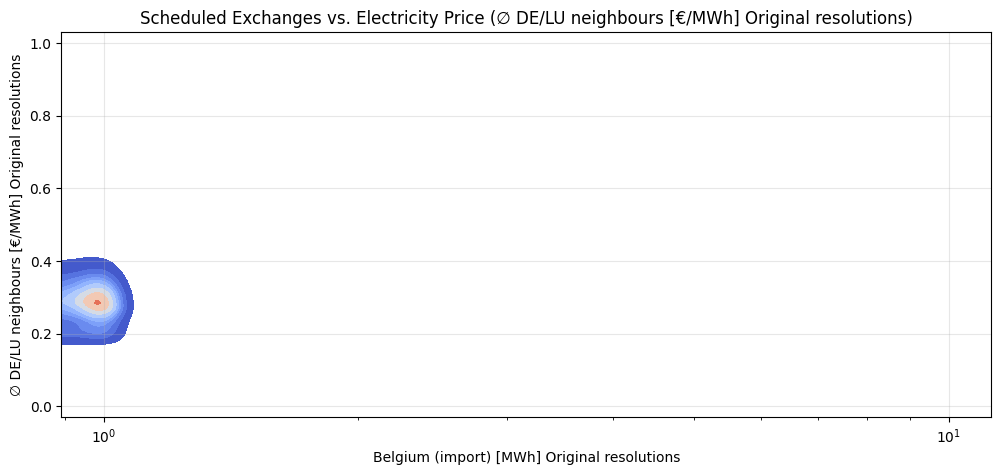

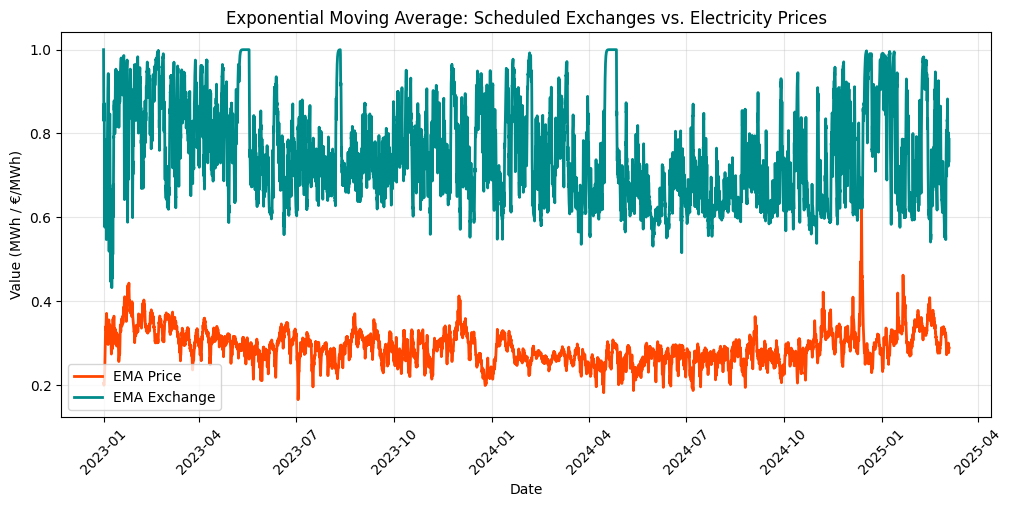

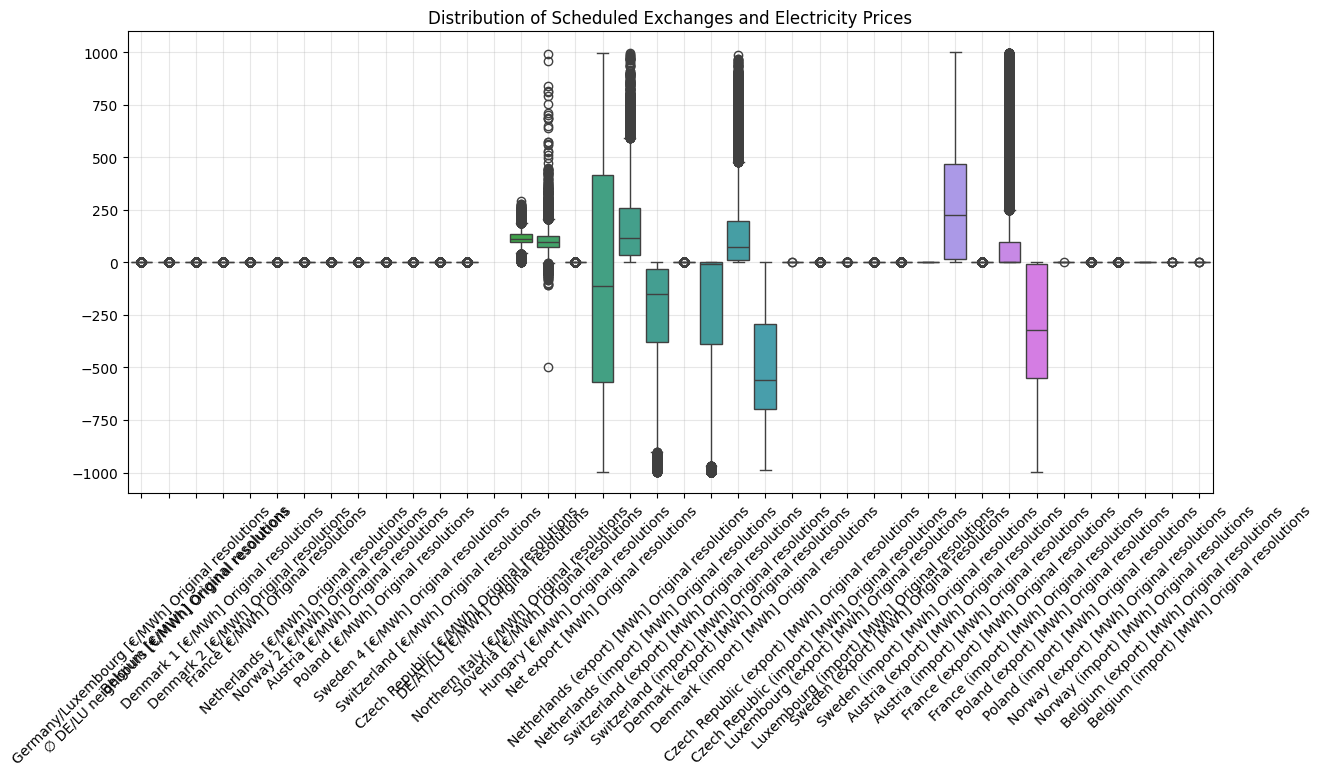

✅ Scheduled exchanges plots saved


In [5]:
### --- Scheduled Exchanges vs. Electricity Price --- ###

# Convert time column to datetime
df_exchanges["Start date"] = pd.to_datetime(df_exchanges["Start date"], errors="coerce")
df_prices["Start date"] = pd.to_datetime(df_prices["Start date"], errors="coerce")

# Merge datasets on Start date
df_merged = df_prices.merge(df_exchanges, on="Start date", how="inner")

# Select price and exchange columns
price_columns = [col for col in df_prices.columns if "€/MWh" in col]
exchange_columns = [col for col in df_exchanges.columns if "[MWh]" in col]

# Convert columns to numeric
df_merged[price_columns] = df_merged[price_columns].apply(pd.to_numeric, errors="coerce")
df_merged[exchange_columns] = df_merged[exchange_columns].apply(pd.to_numeric, errors="coerce")

# Select a sample country for detailed analysis
country_price = price_columns[1]  # Changed from index 0 to 1 for variation
exchange_flow = exchange_columns[-1]  # Changed selection approach

# 📌 **1️⃣ KDE Plot Instead of Scatter Plot**
plt.figure(figsize=(12, 5))
sns.kdeplot(
    x=df_merged[exchange_flow], 
    y=df_merged[country_price], 
    fill=True, cmap="coolwarm"
)
plt.xlabel(exchange_flow)
plt.ylabel(country_price)
plt.title(f"Scheduled Exchanges vs. Electricity Price ({country_price})")
plt.grid(alpha=0.3)
plt.xscale("log")
plt.savefig(os.path.join(PLOTS_DIR, "scheduled_exchanges_vs_price_kde.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# 📌 **2️⃣ Exponential Moving Average Instead of Rolling Average**
df_merged["EMA_Price"] = df_merged[country_price].ewm(span=24, adjust=False).mean()
df_merged["EMA_Exchange"] = df_merged[exchange_flow].ewm(span=24, adjust=False).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_merged["Start date"], df_merged["EMA_Price"], label="EMA Price", color="#FF4500", linewidth=2)
plt.plot(df_merged["Start date"], df_merged["EMA_Exchange"], label="EMA Exchange", color="#008B8B", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Value (MWh / €/MWh)")
plt.title("Exponential Moving Average: Scheduled Exchanges vs. Electricity Prices")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.savefig(os.path.join(PLOTS_DIR, "scheduled_exchanges_vs_price_ema.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# 📌 **3️⃣ Boxplot Instead of FacetGrid**
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_merged[price_columns + exchange_columns])
plt.xticks(rotation=45)
plt.title("Distribution of Scheduled Exchanges and Electricity Prices")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(PLOTS_DIR, "scheduled_exchanges_vs_price_boxplot.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("✅ Scheduled exchanges plots saved")

C:\Users\Elite\AppData\Local\Temp\ipykernel_22928\1822332513.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged.replace("-", np.nan, inplace=True)


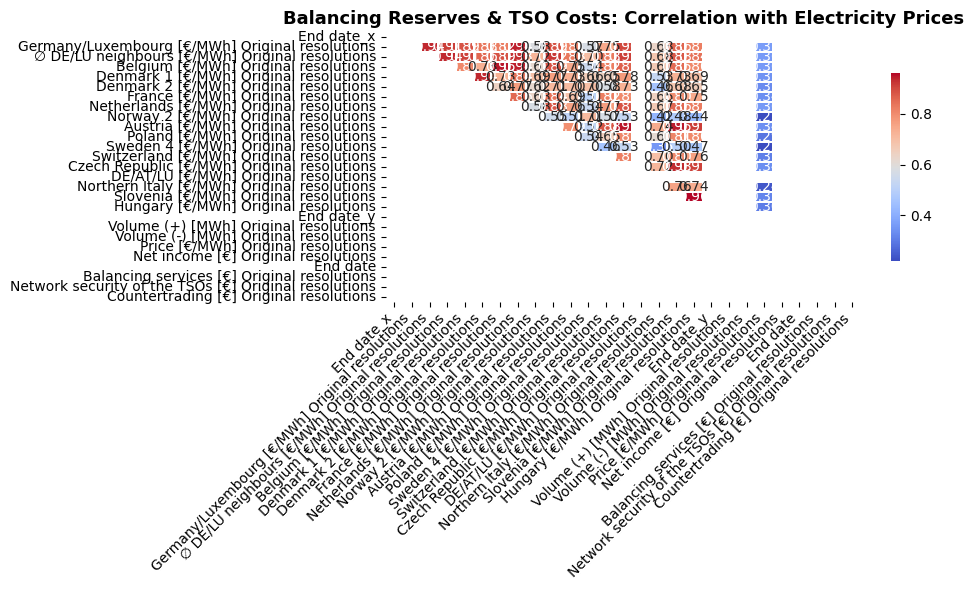

✅ Balancing reserves plots saved


In [7]:
### --- Impact of Balancing Reserves & TSO Costs on Electricity Prices --- ###

# Convert time column to datetime
df_balancing["Start date"] = pd.to_datetime(df_balancing["Start date"], errors="coerce")
df_tso["Start date"] = pd.to_datetime(df_tso["Start date"], errors="coerce")
df_prices["Start date"] = pd.to_datetime(df_prices["Start date"], errors="coerce")

# Merge datasets on Start date
df_merged = df_prices.merge(df_balancing, on="Start date", how="left").merge(df_tso, on="Start date", how="left")

# Replace non-numeric values (e.g., '-') with NaN
df_merged.replace("-", np.nan, inplace=True)

# Convert all numeric columns properly (handling thousand separators)
for col in df_merged.columns:
    df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce")

# Fill missing values with median to ensure consistency
df_merged.fillna(df_merged.median(numeric_only=True), inplace=True)

# Sort by date for consistency
df_merged = df_merged.sort_values("Start date").set_index("Start date")

# Select numeric columns only
df_numeric = df_merged.select_dtypes(include=["number"])

# Compute Spearman correlation matrix (alternative to Pearson for better capturing nonlinear relationships)
corr_matrix = df_numeric.corr(method="spearman")

# Create a mask for the lower triangle (to ensure different visual representation)
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap with adjusted aesthetics
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="coolwarm",  # Switched back to highlight positive/negative correlations
    fmt=".2f",       # Standardized decimal format
    linewidths=0.3,   # Subtle grid lines
    mask=mask,        # Show only lower triangle
    cbar_kws={"shrink": 0.7}  # Adjusted colorbar size
)

plt.title("Balancing Reserves & TSO Costs: Correlation with Electricity Prices", fontsize=13, fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "balancing_reserves_tso_correlation_v2.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"✅ Balancing reserves plots saved")


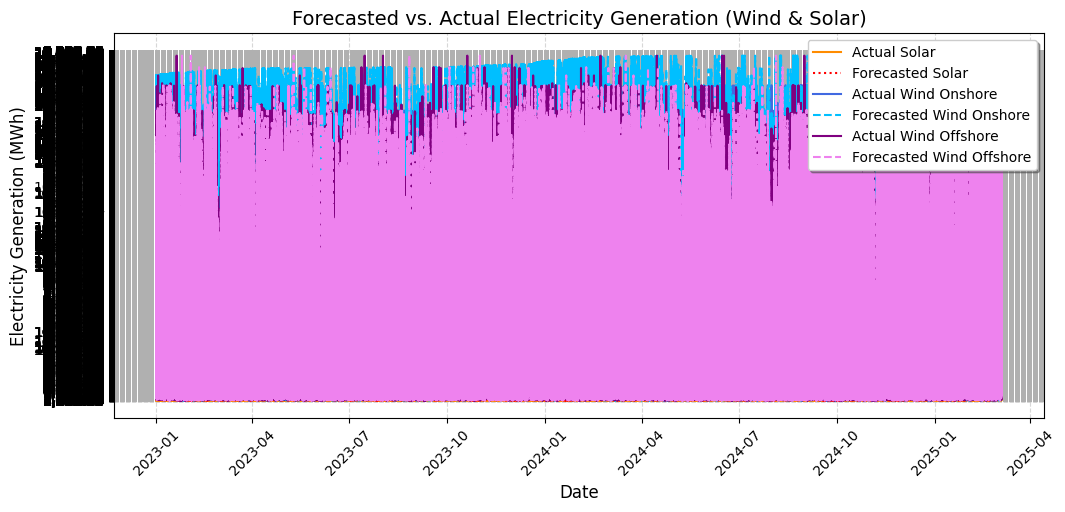

Forecast vs actual generation plot saved


In [8]:
### --- Plot Actual vs Forecasted Generation (Wind + Solar) --- ###

# Convert time column to datetime
df_generation["Start date"] = pd.to_datetime(df_generation["Start date"])
df_forecast["Start date"] = pd.to_datetime(df_forecast["Start date"])

# Select relevant columns
actual_columns = [
    "Start date",
    "Photovoltaics [MWh] Original resolutions",
    "Wind offshore [MWh] Original resolutions",
    "Wind onshore [MWh] Original resolutions"
]

forecast_columns = [
    "Start date",
    "Photovoltaics [MWh] Original resolutions",
    "Wind offshore [MWh] Original resolutions",
    "Wind onshore [MWh] Original resolutions",
    "Total [MWh] Original resolutions"  # Includes all generation sources
]

df_actual = df_generation[actual_columns]
df_forecast = df_forecast[forecast_columns]

# Merge datasets on Start date
df_merged = df_actual.merge(df_forecast, on="Start date", suffixes=("_actual", "_forecast"))

# Sort by date for better visualization
df_merged = df_merged.sort_values("Start date").set_index("Start date")

# Plot Actual vs Forecasted Generation (Wind + Solar)
plt.figure(figsize=(12, 5))

plt.plot(df_merged.index, df_merged["Photovoltaics [MWh] Original resolutions_actual"], label="Actual Solar", color="darkorange", linewidth=1.5)
plt.plot(df_merged.index, df_merged["Photovoltaics [MWh] Original resolutions_forecast"], label="Forecasted Solar", linestyle="dotted", color="red", linewidth=1.5)

plt.plot(df_merged.index, df_merged["Wind onshore [MWh] Original resolutions_actual"], label="Actual Wind Onshore", color="royalblue", linewidth=1.5)
plt.plot(df_merged.index, df_merged["Wind onshore [MWh] Original resolutions_forecast"], label="Forecasted Wind Onshore", linestyle="dashed", color="deepskyblue", linewidth=1.5)

plt.plot(df_merged.index, df_merged["Wind offshore [MWh] Original resolutions_actual"], label="Actual Wind Offshore", color="purple", linewidth=1.5)
plt.plot(df_merged.index, df_merged["Wind offshore [MWh] Original resolutions_forecast"], label="Forecasted Wind Offshore", linestyle="dashed", color="violet", linewidth=1.5)

plt.xticks(rotation=45)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Electricity Generation (MWh)", fontsize=12)
plt.title("Forecasted vs. Actual Electricity Generation (Wind & Solar)", fontsize=14)
plt.legend(fontsize=10, loc="upper right", shadow=True)
plt.grid(True, linestyle="--", alpha=0.5)

# Save and show the plot
plt.savefig(os.path.join(PLOTS_DIR, "forecast_vs_actual_generation.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"Forecast vs actual generation plot saved")

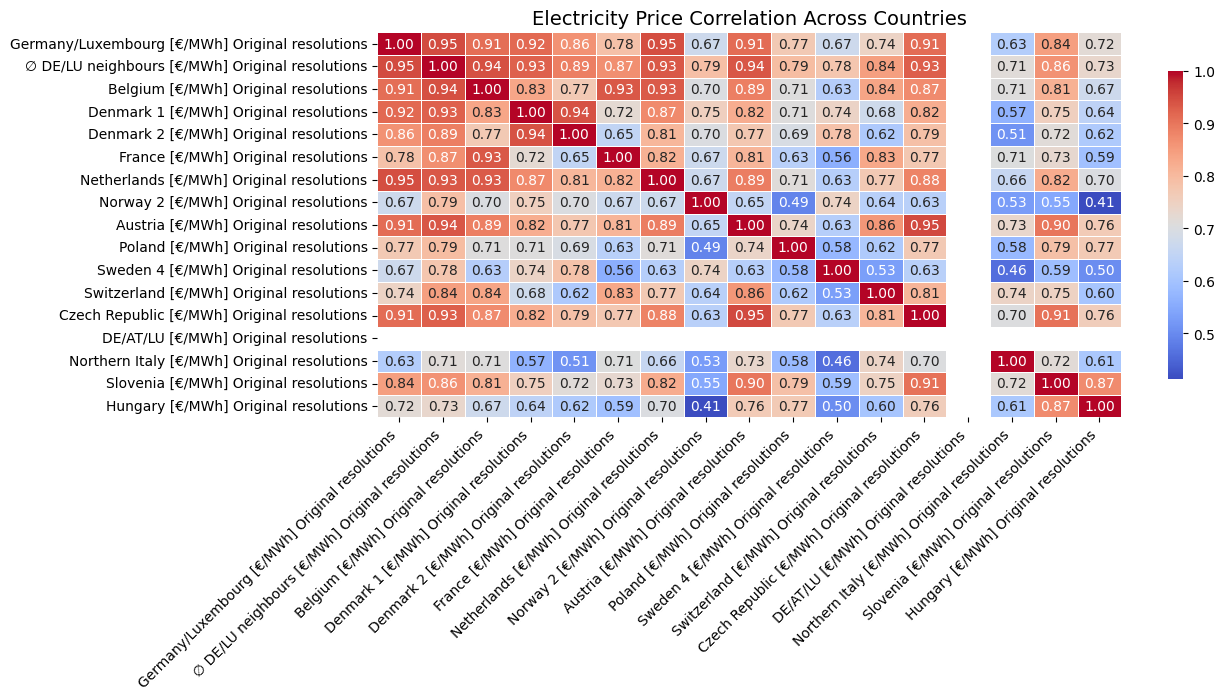

Electricity price correlation plot saved


In [9]:
### --- Electricity Price Correlation Across Countries --- ###

# Convert time column to datetime
df_prices["Start date"] = pd.to_datetime(df_prices["Start date"], errors="coerce")

# Select electricity price columns (ensuring no unwanted columns)
price_columns = [col for col in df_prices.columns if "€/MWh" in col and "Original resolutions" in col]

# Convert price columns to numeric, forcing errors to NaN
df_prices[price_columns] = df_prices[price_columns].apply(pd.to_numeric, errors="coerce")

# Drop rows where all price values are NaN
df_prices.dropna(subset=price_columns, how="all", inplace=True)

# Compute correlation matrix
corr_matrix = df_prices[price_columns].corr()

# Plot heatmap with refinements
plt.figure(figsize=(12, 5))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8}
)
plt.title("Electricity Price Correlation Across Countries", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(os.path.join(PLOTS_DIR, "country_electricity_price_correlation.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"Electricity price correlation plot saved")

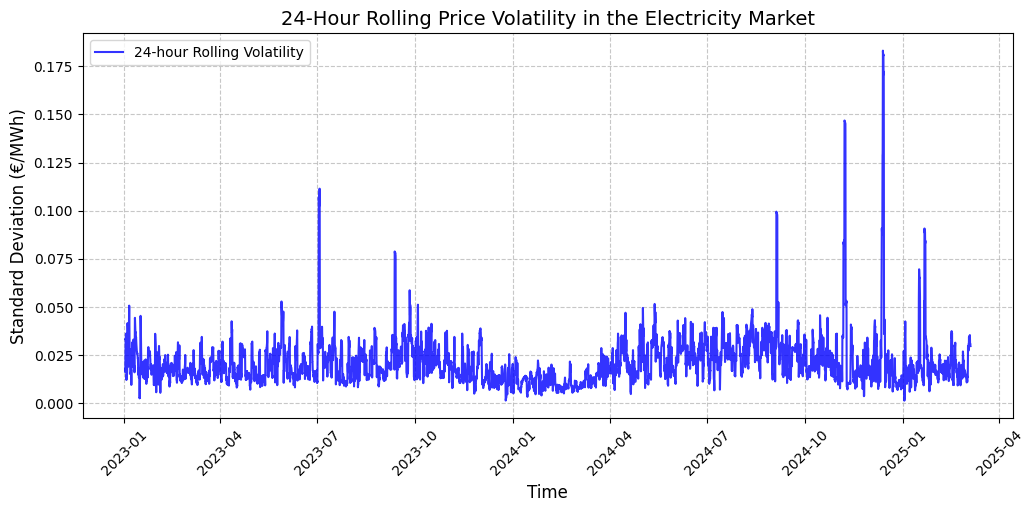

Electricity price volatility plot saved


In [10]:
### --- Electricity Price Volatility Trend --- ###

# Convert time column to datetime
df_prices["Start date"] = pd.to_datetime(df_prices["Start date"])

# Compute rolling standard deviation (volatility)
df_prices["Price Volatility"] = df_prices["Germany/Luxembourg [€/MWh] Original resolutions"].rolling(window=24).std()

# Plot volatility
plt.figure(figsize=(12, 5))
plt.plot(df_prices["Start date"], df_prices["Price Volatility"], label="24-hour Rolling Volatility", color="blue", linewidth=1.5, alpha=0.8)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Standard Deviation (€/MWh)", fontsize=12)
plt.title("24-Hour Rolling Price Volatility in the Electricity Market", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.savefig(os.path.join(PLOTS_DIR, "electricity_price_volatility_trend.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("Electricity price volatility plot saved")

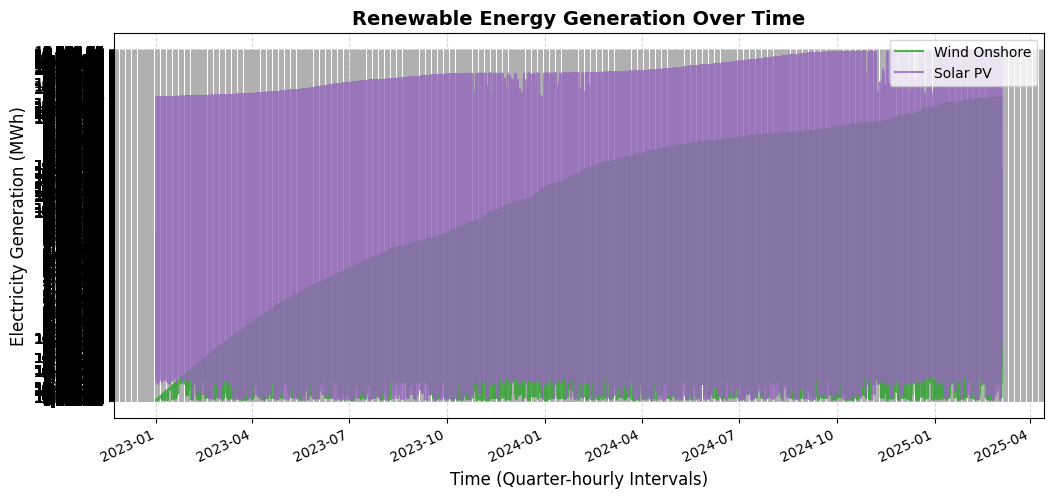

Renewable generation trend plot saved


In [12]:
### --- Plot Renewable Generation Trends --- ###

# Convert time column to datetime
df_generation["Start date"] = pd.to_datetime(df_generation["Start date"])

# --- Plot Renewable Generation Trends ---
plt.figure(figsize=(12, 5))

plt.plot(
    df_generation["Start date"], 
    df_generation["Wind onshore [MWh] Original resolutions"], 
    label="Wind Onshore", color="tab:green", linewidth=1.5, alpha=0.8
)

plt.plot(
    df_generation["Start date"], 
    df_generation["Photovoltaics [MWh] Original resolutions"], 
    label="Solar PV", color="tab:purple", linewidth=1.5, alpha=0.8
)

plt.xlabel("Time (Quarter-hourly Intervals)", fontsize=12)
plt.ylabel("Electricity Generation (MWh)", fontsize=12)
plt.title("Renewable Energy Generation Over Time", fontsize=14, fontweight="bold")
plt.legend(fontsize=10, loc="upper right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=25, ha="right", fontsize=10)

# Save plot
plot_filename = "renewable_energy_generation_trend.png"
plt.savefig(os.path.join(PLOTS_DIR, plot_filename), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"Renewable generation trend plot saved")


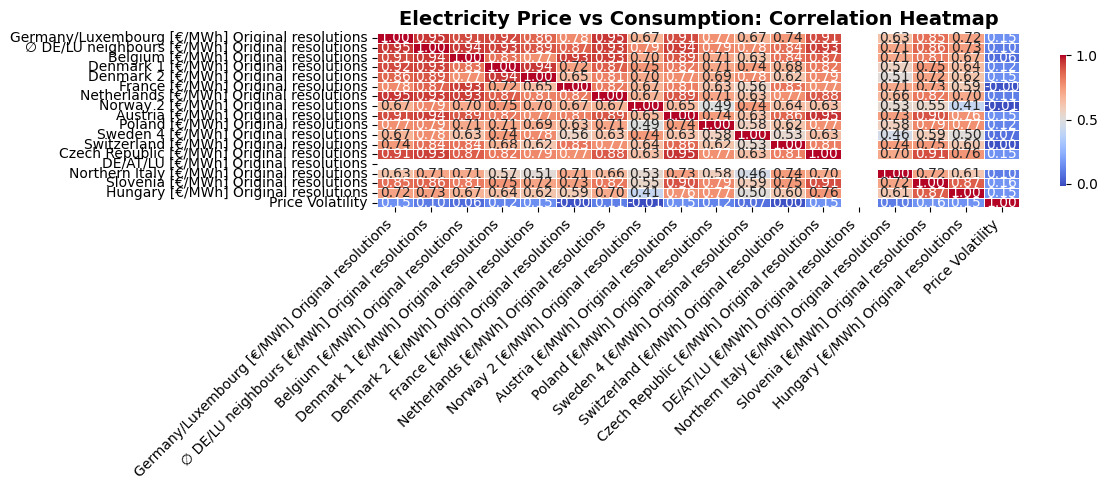

Electricity price vs consumption plot saved


In [13]:
### --- Electricity Price vs Consumption: Correlation Heatmap --- ###

# Convert time columns to datetime
df_prices["Start date"] = pd.to_datetime(df_prices["Start date"])
df_consumption["Start date"] = pd.to_datetime(df_consumption["Start date"])

# Merge datasets on "Start date"
df_merged = df_prices.merge(df_consumption, on="Start date", how="inner")

# Drop non-numeric columns
df_numeric = df_merged.select_dtypes(include=["number"])

# Compute correlation matrix
corr_matrix = df_numeric.corr()

# --- Plot Heatmap ---
plt.figure(figsize=(12, 5))
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
    linewidths=0.5, cbar_kws={"shrink": 0.75}, annot_kws={"size": 10}
)

plt.title("Electricity Price vs Consumption: Correlation Heatmap", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save plot
heatmap_filename = "electricity_price_consumption_correlation.png"
plt.savefig(os.path.join(PLOTS_DIR, heatmap_filename), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"Electricity price vs consumption plot saved")

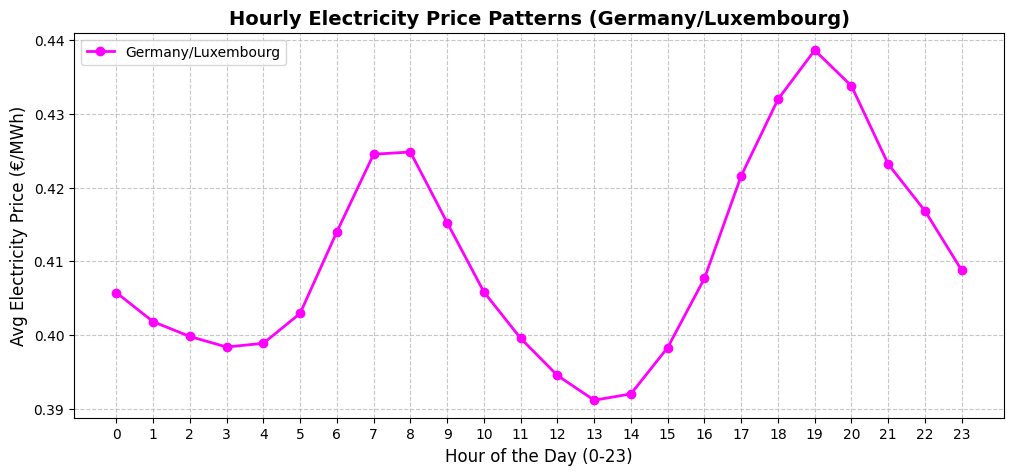

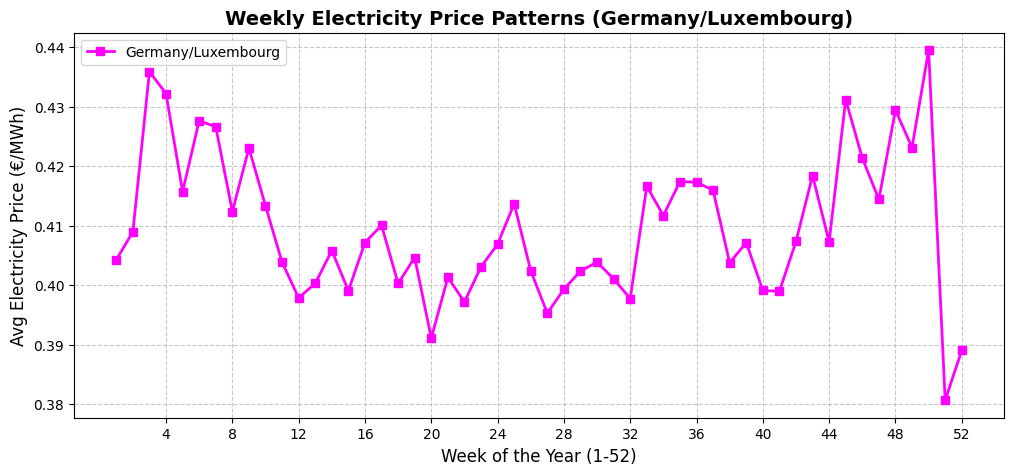

Hourly and weekly electricity price plot saved


In [19]:
### --- Hourly and Weekly Electricity Price Patterns (Germany/Luxembourg) --- ###

# Convert time column to datetime
df_prices["Start date"] = pd.to_datetime(df_prices["Start date"])

# Extract time components
df_prices["Hour"] = df_prices["Start date"].dt.hour
df_prices["Week"] = df_prices["Start date"].dt.isocalendar().week.astype(int)

# Ensure the target column is numeric
price_col = "Germany/Luxembourg [€/MWh] Original resolutions"
df_prices[price_col] = pd.to_numeric(df_prices[price_col], errors="coerce")

# Drop NaN values
df = df_prices.dropna(subset=[price_col])

# Compute hourly and weekly averages
hourly_prices = df.groupby("Hour")[price_col].mean()
weekly_prices = df.groupby("Week")[price_col].mean().sort_index()

# --- Plot Hourly Trends ---
plt.figure(figsize=(12, 5))
plt.plot(hourly_prices.index, hourly_prices, label="Germany/Luxembourg", color="magenta", marker="o", markersize=6, linewidth=2)

plt.xlabel("Hour of the Day (0-23)", fontsize=12)
plt.ylabel("Avg Electricity Price (€/MWh)", fontsize=12)
plt.title("Hourly Electricity Price Patterns (Germany/Luxembourg)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(range(0, 24))
plt.savefig(os.path.join(PLOTS_DIR, "hourly_electricity_price_trends.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# --- Plot Weekly Trends ---
plt.figure(figsize=(12, 5))
plt.plot(weekly_prices.index, weekly_prices, label="Germany/Luxembourg", color="magenta", marker="s", markersize=6, linewidth=2)

plt.xlabel("Week of the Year (1-52)", fontsize=12)
plt.ylabel("Avg Electricity Price (€/MWh)", fontsize=12)
plt.title("Weekly Electricity Price Patterns (Germany/Luxembourg)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(range(4, 53, 4))  # Show every 4th week for better readability
plt.savefig(os.path.join(PLOTS_DIR, "weekly_electricity_price_trends.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"Hourly and weekly electricity price plot saved")
